# This AIMS Jupyter Notebook is customized for recreating the data in Mason & Latour et al.
Here with have special additional scripts for handling TCRs processed in CellRanger (10x Genomics).

Further down, we then have ways to match the TCR barcodes to the GEX barcodes for visualizing GEX of certain TCR clusters.

# Obviously the data are too large to include in the GitHub. Hopefully we'll have that uploaded to Zenodo soon

# Section 0: Loading in Modules and Defining Figure Formatting
This first cell is just loading in all of the necessary python modules (which you should have already installed) and defining figure font, size, etc.

In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
import pandas

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-14:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_loader as aimsLoad
import aims_analysis as aims
import aims_classification as classy

# This bit is for that figure formatting. Change font and font size if desired
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

# Lastly this custom colormap is for 
import matplotlib as mpl
upper = mpl.cm.jet(np.arange(256))
lower = np.ones((int(256/4),4))
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])
cmap = np.vstack(( lower, upper ))
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])
#import h5py

# Alright so we're going to change our typical AIMS pipeline a little bit.
All in the same notebook, let's process the data *first*, and then incorporate the metadata.

Ideal to have it all in one place for now. Maybe clean up later

# This below cell was specfically for formatting 10x VDJ Outputs for AIMS
Note that you probably shouldn't need to run this because I assume I'll upload all these file individually,
but it might be worth it for users to see how the sausage is made

In [2]:
datdir = 'tau_10x/'
# Seems silly to use "subdir" but we 
# Then call on subdir to name our files
subdir = 'SC_CD8_vdj_t/'
filename = 'filtered_contig_annotations.csv'
aims.process_save_10x(datdir,subdir,filename)

# As sort of a preamble, let's make sure that we load in all of our barcode data, and try some tests to match with GEX

In [3]:
# Need to define this because the barcodes have an extra sample tag on them in the 
# Files processed by Kory
def reformat_barcodes(barcodes,num):
    temp = []
    for i in np.arange(len(barcodes)):
        temp = temp + [barcodes.values[i][0]+'_'+str(num)]
    fin = pandas.DataFrame(temp,columns=[barcodes.columns])
    return(fin)

datDir = 'tau_10x/AIMS_format_tcrs/'
ln_cd4_preCode = pandas.read_csv(datDir+'LN_CD4_barcodes.csv')
ln_cd4_barcodes = reformat_barcodes(ln_cd4_preCode,1)
ln_cd8_preCode = pandas.read_csv(datDir+'LN_CD8_barcodes.csv')
ln_cd8_barcodes = reformat_barcodes(ln_cd8_preCode,2)
sc_cd4_preCode = pandas.read_csv(datDir+'SC_CD4_barcodes.csv')
sc_cd4_barcodes = reformat_barcodes(sc_cd4_preCode,3)
sc_cd8_preCode = pandas.read_csv(datDir+'SC_CD8_barcodes.csv')
sc_cd8_barcodes = reformat_barcodes(sc_cd8_preCode,4)

# Now, load in some data that we can use to call these barcodes
gexDir = 'tau_10x/'
gexTag = pandas.read_csv(gexDir+'UMI_gex_clusterTags.csv')

# Load in the accompanying GEX

In [4]:
# So this normalized file is pretty small, but if you wanted to run this analysis on raw GEX it can be quite slow

gexDF = pandas.read_csv(gexDir+'normalized_tau_gex.csv')

# Now it just goes back to standard AIMS analysis for a little bit

In [5]:
#####################
"""
Throughout this notebook, I will try to include comments like this where explanations are important
Use the below information to alter this code for your own personal analysis
- molecule is either "Ig","MSA", or "peptide"
- datDir is the location of your data
- outputDir is where figures will be saved
    -If you need help understanding how to define these "Dirs" go to the ReadTheDocs website
- fileName is a list of the full dataset filenames
- datName is a more human readable title for the data
"""
#####################

#datDir = "app_data"
datDir = 'tau_10x/AIMS_format_tcrs'
outputDir = "tau_out"
# If the output directory doesn't exist, make it
# If the input directory doesn't exist... what are you doing
try: 
    os.listdir(outputDir)
except:
    os.makedirs(outputDir)

# An example of what Ig analysis looks like
######################################
molecule = 'Ig'
# Keep the brackets, even if only analyzing a single file
#fileName = ["siv_tl8.csv","siv_cm9.csv"]
fileName = ['LN_CD4_tcrs.csv','LN_CD8_tcrs.csv','SC_CD4_tcrs.csv','SC_CD8_tcrs.csv']
#fileName = ['LN_CD8_tcrs.csv','SC_CD8_tcrs.csv']
datName = ["LN_CD4","LN_CD8","SC_CD4","SC_CD8"]
######################################

# An example of what Peptide analysis looks like
######################################
#molecule = 'Peptide'
# Keep the brackets, even if only analyzing a single file
#fileName = ["kidney_hla_atlas.csv","pancreas_hla_atlas.csv"]
#datName = ["Kidney","Pancreas"]
######################################

# An example of what MSA analysis looks like
######################################
#molecule = 'MSA'
# Keep the brackets, even if only analyzing a single file
#fileName = ["cd1.fasta","fish.fasta","classIa.fasta"]
#datName = ["CD1","FishMHC","ClassIa"]
######################################

# If analyzing Ig molecules, define number of CDR loops you want to analyze
# If analyzing MSA, keep this defined anyway as a dummy variable. Won't change anything
num_loop = 6
# Do you want AIMS to drop duplicate sequences (clonal expansion or otherwise)?
drop_duplicates = False

# If running on a mac, set parallel process to True for a speedup in analysis
# parallel processing has not yet been tested on other (non macOS) operating systems
parallel_process = False

# In the Below Cell We Convert Our Sequences to an AIMS-Readable Format

If there are downstream issues in the first section where figures are generated (Section 2) come back here and check formatting of the outputs here

# In this Section We Also Determine if We Want Subsets of the Data to be Taken

For instance, you may be interested in only a select region of the MSA or only a subset of the included CDR loops

In the example subset we provide, we are selecting out regions of the MHC MSA that correspond to consensus alignments of the MHC alpha-helices and beta-strands

In [6]:
##################################################################
# Note, you can't really take a subset of peptide data
subset = False
##################################################################
if subset:
    if molecule.lower() == 'ig':
        # So num_loop WAS defined before, but redefine here if you want to change it
        num_loop = 1
    elif molecule.lower() == 'msa':
        # Define the positions in the alignment you want to focus on
        # An MSA subset is recommended, otherwise processing could be slow
        # Define, in order, the starts and ends of each feature of interest
        # YOU MUST HAVE THE SAME NUMBER OF ENTRIES IN EACH VARIABLE
        subset_starts = [164,214,275,327]
        subset_ends =   [214,275,327,376]

if len(fileName) != len(datName):
    print("A mistake! You don't have the proper number of labels for your files")
elif molecule.lower() == 'ig':
    for i in np.arange(len(fileName)):
        seq_pre = aimsLoad.Ig_loader(datDir+'/'+fileName[i],label=datName[i],loops=num_loop,drop_degens = drop_duplicates)
        if i == 0:
            seqPRE = seq_pre
        else:
            seqPRE = pandas.concat([seqPRE,seq_pre],axis=1)
    seqF = seqPRE
elif molecule.lower() == 'peptide':
    for i in np.arange(len(fileName)):
        seq_pre = aimsLoad.pep_loader(datDir+'/'+fileName[i],label=datName[i])
        if i == 0:
            seqPRE = seq_pre
        else:
            seqPRE = pandas.concat([seqPRE,seq_pre],axis=1)
    seqF = seqPRE
elif molecule.lower() == 'msa':
    for i in np.arange(len(fileName)):
        seq_pre = aimsLoad.msa_loader(datDir+'/'+fileName[i],label=datName[i],drop_dups = drop_duplicates)
        if i == 0:
            seqAll = seq_pre
        else:
            seqAll = pandas.concat([seqAll,seq_pre],axis=1)
    # Have to reshape our sequences
    seqs = np.array(seqAll.loc[0].values).reshape(1,len(seqAll.loc[0].values))
    seqPRE = pandas.DataFrame(seqs)
    seqPRE.columns = seqAll.columns
    if subset:
        seqF = aims.get_msa_sub(seqPRE,subset_starts,subset_ends)
    else:
        seqF = seqPRE
    # Save our FASTA headers as metadata. May be useful downstream or not
    metaF = seqAll.loc[1]

# You Shouldn't Need to Change any of The Below Code

In [7]:
mat_size = aims.get_sequence_dimension(np.array(seqF))[0]

# General changes that need to be done for every type of molecule
AA_num_key = aims.get_props()[1]
if num_loop != 1:
    for i in np.arange(len(mat_size)):
        if i == 0:
            xtick_loc = [mat_size[i]/2]
        else:
            pre_loc = sum(mat_size[:i])
            xtick_loc = xtick_loc + [mat_size[i]/2 + pre_loc]
    else:
        xtick_loc = mat_size/2

# Section 2: Sequence Visualization via AIMS Matrix Encoding

If looking at Ig molecules, you can decide if you would like to align to the center, left, or right of each sequence.

There is a 3rd option, "bulge" which aligns the germline regions of CDR3 (and other loops) and then center aligns what is left. 

Change the 'align' variable to one of these four. Pretty easy to visualize each time you do so in below matrix

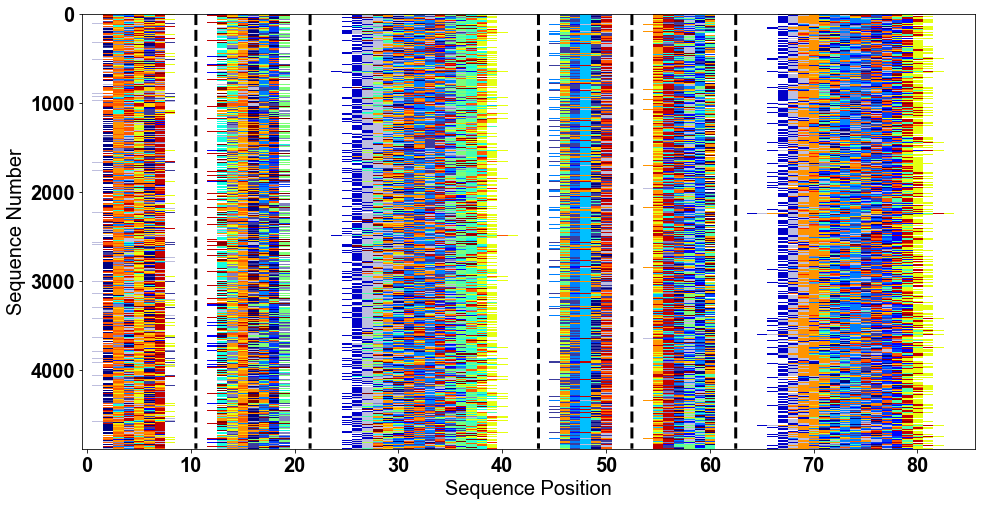

In [8]:
#################################
# The "align" option only changes alignments for Ig, not MSA encodings
align = 'center'
# This "pad" value only changes things if your alignemnt is "bulge"
# Otherwise keep it defined as 8, again another dummy variable that you need to keep
pad = 6
#################################

if molecule.lower() == 'ig':
    seq_MIpre = aims.gen_tcr_matrix(np.array(seqF),key = AA_num_key, giveSize = mat_size, alignment = align, bulge_pad=pad)
elif molecule.lower() == 'peptide':
    seq_MIpre = aims.gen_tcr_matrix(np.array(seqF),key = AA_num_key, giveSize = mat_size, alignment = align, bulge_pad=pad)
elif molecule.lower() == 'msa':
    AA_num_key_dash = np.hstack((AA_num_key,[0]))
    seq_MIpre = aims.gen_MSA_matrix(np.array(seqF),key = AA_num_key_dash, giveSize = mat_size)

seq_MIf = pandas.DataFrame(np.transpose(seq_MIpre),columns = seqF.columns)

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(np.transpose(seq_MIf), interpolation='nearest', aspect='auto',cmap=cmap)
ax[0,0].set_ylabel('Sequence Number')

######
# It will help to have vertical dashed black lines to guide the viewer
seq1_len = np.shape(seqF)[1]
Numclones = int(seq1_len)
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(Numclones),np.arange(Numclones),'k--',linewidth = 3)
#######
ax[0,0].set_xlabel('Sequence Position')
#pl.savefig(outputDir+'/AIMS_mat.pdf',format='pdf')

# Section 3: Calculate our Biophysical Property Matrices
Depending on what type of analysis you are doing, this will likely be the slowest step in this entire notebook

The only thing that you *might* need to change in the below code is the decision to normalize the biophysical properties or not. Default is to normalize

# NOTE: In the new version of AIMS you can entropy-reweight this matrix. We didn't do that for this manuscript.

In [9]:
# Process this new matrix and apply biophysical propery "masks"
# This has to be changed from the binary case, because we aren't looking for differences
normalize = True
dsetF = seqF.values

if molecule.lower() == 'ig':
    special = ''
elif molecule.lower() == 'peptide':
    special = ''
elif molecule.lower() == 'msa':
    special = 'MSA'

#################### PARALLEL PROCESSING TO CREATE BIG MATRIX #######################
if parallel_process:
    import multiprocessing as mp
    def boot_it(data):
        bigass = classy.get_bigass_matrix(dsetF[:,data[0]:data[1]], giveSize = mat_size, alignment = align,special = special, norm=normalize,bulge_pad=pad)
        return(bigass)
    def do_boot(data):
        with mp.Pool() as pool:
            results = pool.map(boot_it, data)
            return(results)
    if __name__ == "__main__":
        # Probably a smarter way to calculate #seqs per node, but do 100 for now
        final = aims.gen_splits(splitMat = seq_MIf, splitSize = 100)
        big_pre = do_boot(final)
    total_mat = np.concatenate(big_pre, axis = 0)
else:
    #################### Or, Don't Parallelize to CREATE BIG MATRIX #######################
    bigass = classy.get_bigass_matrix(dsetF, giveSize = mat_size, alignment = align, norm = normalize,special=special,bulge_pad=pad )
    total_mat = bigass
    
# Generate a large list of property names and matrix positions so you can pinpoint strong
# contributors to discrimating features between datasets or clusters
prop_list_old = ['Phobic1','Charge','Phobic2','Bulk','Flex','Kid1','Kid2','Kid3','Kid4','Kid5','Kid6','Kid7','Kid8','Kid9','Kid10']
prop_list_new = ['Hot'+str(b+1) for b in range(46)]
prop_names = prop_list_old + prop_list_new
num_locs = int(np.shape(total_mat)[1]/61)
Bigass_names = []
for i in prop_names:
    for j in np.arange(num_locs):
        Bigass_names = Bigass_names + [ i + '-' + str(j) ]

# Drop Highly Correlated Vectors and Vectors where entry=0 for all entries
###### Currently drop vectors with over 0.75 corr. coef. ################
full_big = pandas.DataFrame(total_mat,columns = Bigass_names)
drop_zeros = [column for column in full_big.columns if all(full_big[column] == 0 )]
y = full_big.drop(full_big[drop_zeros], axis=1)
z_pre = np.abs(np.corrcoef(np.transpose(y)))
z = pandas.DataFrame(z_pre,columns=y.columns,index=y.columns)
# Select upper triangle of correlation matrix
upper = z.where(np.triu(np.ones(z.shape), k=1).astype(bool))
# If you did want to change that corr. coef. cutoff, do so here
to_drop = [column for column in upper.columns if ( any(upper[column] > 0.75) ) ]

# Your final product of a parsed matrix
parsed_mat = y.drop(y[to_drop], axis=1)

# Let's have some default metadata we can pull from later
tokenized_dset = []
for i in np.arange(len(datName)):
    for j in seqF.columns:
        if str(j).find(datName[i]) != -1:
            tokenized_dset.append(i)
token_df = pandas.DataFrame(tokenized_dset,columns=['ID'])
IDed_full_big = pandas.concat([full_big,token_df],axis=1)

# Lastly, create a good-ole traditional averaged bphys property matrix
# i.e. each sequence gets a single value for averaged charge, averaged flexibility, etc...
posLen,seqLen = np.shape(seq_MIf)
# The 61 is hardcoded here because it is our number of properties. Eventually we will let users define which properties to use
seq_bigReshape = np.array(full_big).reshape(seqLen,61,posLen)

# Section 4: Sequence Projection & Clustering

# The next few cells are particularly powerful for isolating interesting populations in the dataset using PCA, UMAP, and KMeans Clustering

This is really a section where you should take your time and toggle some of these settings. Look at your data using PCA and UMAP

Try to use "full", "parse", or "avg" biophysical properties for each entry as input into the dimensionality reduction 

The below cell is important to define, so we set it apart from the rest of the code

# These settings as-is are what we did for the manuscript, but you can change them if you want to explore the data a bit

In [10]:
# DEFINE WHICH FORM OF THE DATASET YOU WOULD LIKE TO ANALYZE HERE
# Perform dim. red. on the whole dataset? enter "full"
# Want to do it on a dataset with highly correlated vectors removed? enter "parse"
# Lastly, can just do it on a matrix of the per-sequence average over 61 props? enter "avg"
###################################################################################
# enter "full", "parse", or "avg"
dchoice = 'parse'

# Then, choose which dimensionality reduction and clustering method you want to use
# Want to run pca or umap?
reduce = 'umap'
# What will you cluster with (kmean, optics, dbscan)?
clust = 'optics'
###################################################################################

# The below section then uses the above information to actually calculate these things

There is a lot of opportunity to go EVEN deeper into the code here to tweak your analysis. Important to do if you really care about the data. Alter things like:
- Nclust for Kmeans
- min_samples for OPTICS
- eps for DBSCAN
- Setting random seeds for UMAP (see the ReadTheDocs for the disclaimer for using UMAP)

In [11]:
# Don't change these if statements, change the stuff below that
if dchoice.lower() == 'full':
    chosen_dset = full_big
elif dchoice.lower() == 'parse':
    chosen_dset = parsed_mat
elif dchoice.lower() == 'avg':
    chosen_dset = np.average(seq_bigReshape,axis=2)

if reduce == 'pca':
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3, svd_solver='full')
    final=pca.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
    print("PCA Explained Variance Ratio:")
    print(pca.explained_variance_ratio_)
elif reduce == 'umap':
    import umap
    reducer = umap.UMAP(n_components=3, n_neighbors = 25, random_state=42)
    final = reducer.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)

# Cluster the results:
import sklearn.cluster as cluster
clust_input = np.array(np.transpose(transform))
if clust == 'kmean':
    NClust = 3
    clusts = cluster.KMeans(n_clusters=NClust).fit_predict(clust_input)
elif clust == 'optics':
    clusts = cluster.OPTICS(min_samples=10).fit_predict(clust_input)
elif clust == 'dbscan':
    clusts = cluster.DBSCAN(eps=0.3).fit_predict(clust_input)

cluster_dset = pandas.DataFrame(clusts,columns=['cluster'])

# Back to Code Specifically for the Tau Dataset (but more generally in many 10x datasets) we might have a mismatch in TCR # and Metadata #
Need to have some automated way to rectify this. for now do it manually, but we do need a way to make sure that this is consistent

Especially if we are dropping duplicate sequences, we could be removing many sequences from the dataset

In [12]:
# Alright so it turns out we have a single mismatch in the number of entries.
# there is precisely one extra entry in the TCR data that we need to get rid of
ln_cd8_barcodes_pre = ln_cd8_barcodes
seq_pre,index = aimsLoad.Ig_loader(datDir+'/'+fileName[1],label=datName[1],loops=num_loop,drop_degens = drop_duplicates,return_index=True)
ln_cd8_barcodes = ln_cd8_barcodes_pre.loc[index]

In [13]:
# Alright now we're good to match the barcodes:
geneNames = gexDF['Gene']

meta_barcode_pre = pandas.concat([ln_cd4_barcodes,ln_cd8_barcodes,sc_cd4_barcodes,sc_cd8_barcodes])
meta_barcode = meta_barcode_pre.reset_index(drop=True)

# This then gets our GEX Matrix in the same order as our TCR Matrix, so we can visualize metadata

In [14]:
# So a little f***** up here. It looks like the barcodes for the VDJ to not match up with the barcodes for the GEX?
# At least not all of them. So rather than using the barcodes as a column vector, need a FOR loop
tcr_metadat = []
partition_assn = []
cluster_assn = []
for i in meta_barcode.values:
    try:
        tcr_metadat = tcr_metadat + [gexDF[i[0]].values]
    except:
        tcr_metadat = tcr_metadat + [np.zeros(len(geneNames))]
    
    gexSub = gexTag[gexTag['cell']==i[0]]
    if len(gexSub) == 1:
        partition_assn = partition_assn + [gexSub['partitionAssignment'].values[0]]
        cluster_assn = cluster_assn + [gexSub['clusterAssignment'].values[0]]
    elif len(gexSub) == 0:
        partition_assn = partition_assn + [0]
        cluster_assn = cluster_assn + [0]

# So turning the filtered gex DF into a pandas DF takes a while
# Takes a minute, so is what it is
partition_df = pandas.DataFrame(partition_assn,columns=['partition'])
gex_cluster_df = pandas.DataFrame(cluster_assn,columns=['gex_cluster'])
gex_filtered_df = pandas.DataFrame(tcr_metadat,columns=geneNames)

# SECTION 5: Metadata Incorporation

By default, we'll assume that the user DOES NOT have any metadata to add (and the code reflects this), but there are sections to show how metadata could be incorporated are included in the code. The ReadTheDocs will be updated soon to go into more detail here for you to add custom metadata

# If you change "gotMeta" to "True" you can visualize GEX overlaid on the biophysically clustered TCR
We didn't really use this for the manuscript, but this is a useful feature overall and again a good option for some data exploration

In [15]:
# We can incorporate metadata either defining a categorical map or a quantitative map
###################################################################################
# meta_form is either "category" or "quant". Check ReadTheDocs if more descriptions are needed
# If using default metadata (i.e. loaded file), it should be "category"
meta_form = 'category'
gotMeta = False
###################################################################################

if meta_form == 'category':
    if gotMeta:
        ###################################################################################
        # This is an example of how to load in your own metadata
        # Your # metadat entries should match your # sequence entries
        meta = gex_filtered_df
        gene = 'Cd4'
        # A bunch of columns to choose from. Note though, you can
        # only visualize one at a time in the current version
        metadat = pandas.DataFrame(meta[gene])
        metadat.columns = [0]
        ###################################################################################
    else:
        ###################################################################################
        # This is the easiest default metadata definition.
        # Just based on the files that were loaded in (useless if only 1 file)
        metapre = token_df
        # Convert the metadata from numbers to strings
        meta_conv = []
        for i in token_df.values:
            meta_conv.append(datName[i[0]])
        metadat = pandas.DataFrame(meta_conv)
        ###################################################################################
elif meta_form == 'quant':
    # This "quantitative" metadata will just count from 1 to the length of the dataset,
    # coloring the points on the plot in order.
    metaPRE = np.arange(len(token_df))
    metadat = pandas.DataFrame(metaPRE)
    # But, you could add things like MFI, binding affinity, or GEX data for a particular gene

# From there, not much should change unless you want to give a unique name to your metadata
meta_name = 'meta'
meta_map = aims.encode_meta(metadat)
meta_map.columns = [meta_name]
meta_leg = metadat.drop_duplicates().values

# We also need to define our clusters more clearly
clust_map = cluster_dset
clust_leg = [a[0] for a in cluster_dset.drop_duplicates().sort_values('cluster').values]
clust_name = 'cluster'

# Section 6: Plotting Clustering and (Optional) Metadata
The previous section was just for calculating these things. We are now going to provide users with a few different options to visualize their data

By default we show 2D and 3D cluster projections with metadata and clustered data but give users control over which is shown

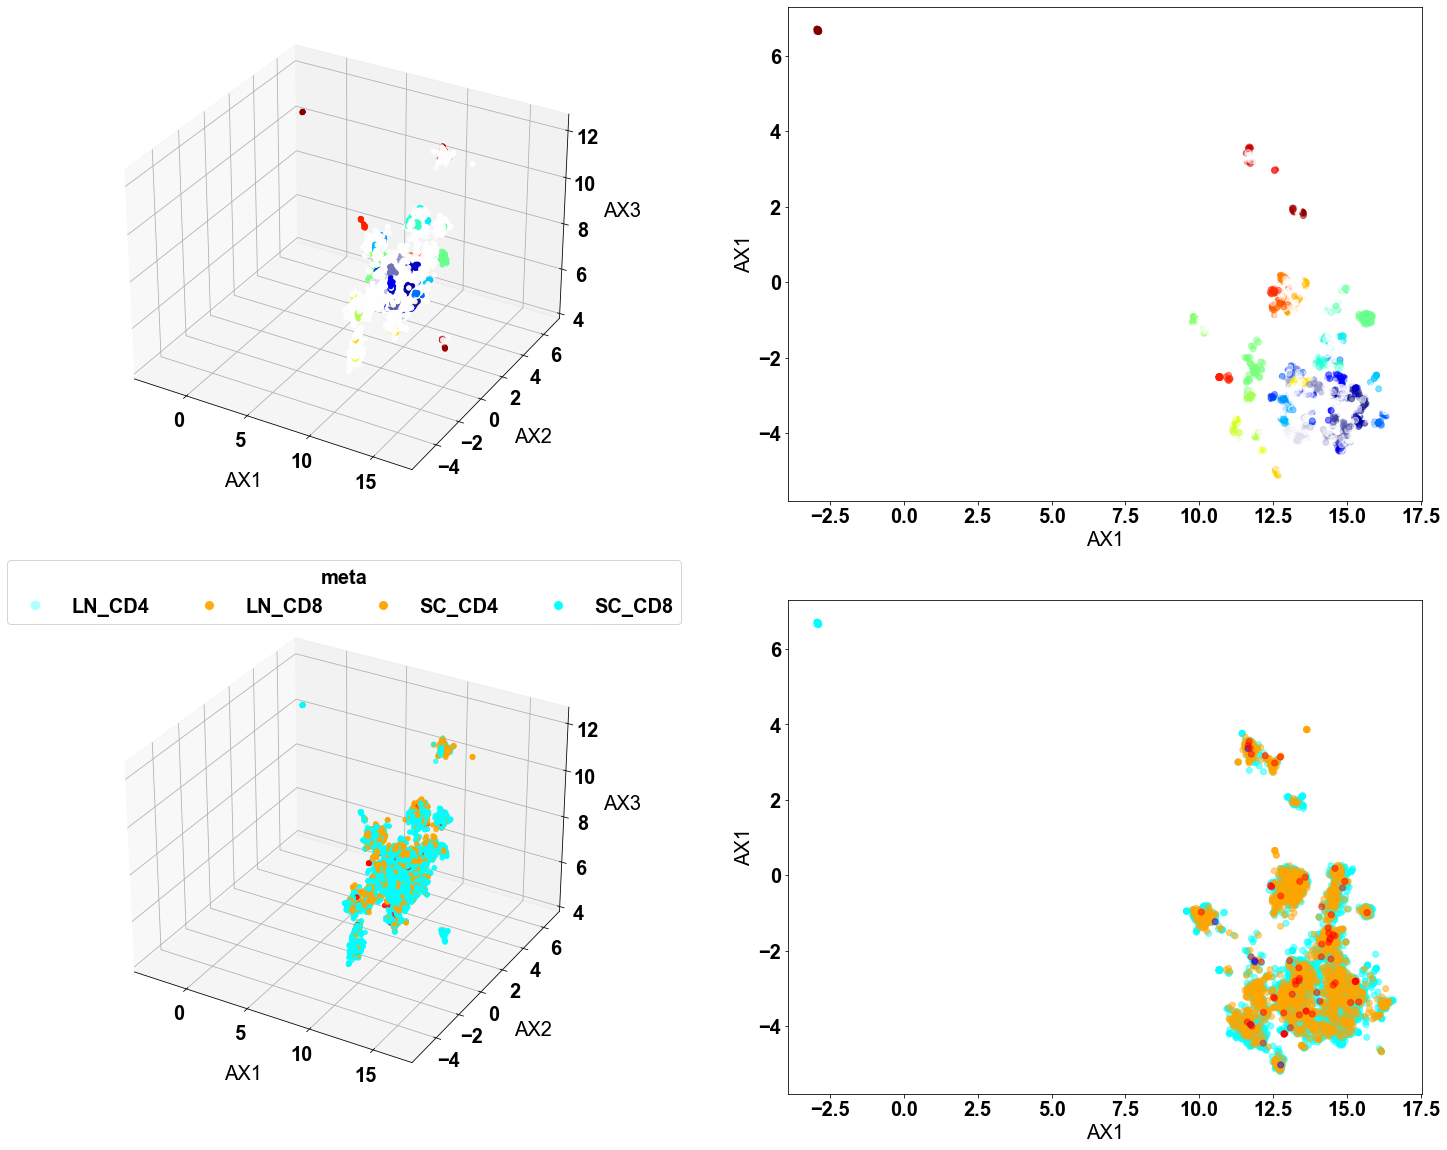

In [16]:
######### Do you want to show 2D projection, 3D, or both?##################
proj_show = 'both'
##########################################################################
######### What about clusters, metadata, or both?##################
clust_show = 'both'
##########################################################################
######### Optionally show labels to identify outlier sequences or sequences of interest##################
# NOTE that these labels really only work well with very few datapoints. Future updates will try to
# work around this issue a little bit better...
show_labels = False
# Could optionally plot other data or change legends if you would like
chosen_map1 = clust_map; leg1 = clust_leg
chosen_map2 = meta_map; leg2 = meta_leg

# Define a colormap to color metadata. Can change this if you want, look at matplotlib colormap options
if gotMeta:
    cmapF = pl.get_cmap('inferno')
else:
    #cmapF = pl.get_cmap('tab20b')
    # Define a custom map for the manuscript
    colors = ['cyan','orange','blue','red']
    from matplotlib.colors import ListedColormap as lcmap
    cmapF = lcmap(colors,name='CustoME')

# So there's no reason to have a function for this, other than to make this notebook look a bit prettier
# Really just defining a bunch of stuff repeatedly with if statements
fig3d,plotloc,plottype,plotem,legends,dattype = aims.get_plotdefs(clust_show,proj_show,chosen_map1,chosen_map2,leg1,leg2)

# Now plot the actual stuff, and save the object handles in a list
colorhandle= []; ax=[]
for i in np.arange(len(plotloc)):
    if dattype[i] == 'clust':
        cmap_use = cmap
    else:
        cmap_use = cmapF
        #cmap_use = newcmp
    if plottype[i] == '3d':
        ax.append(fig3d.add_subplot(plotloc[i],projection=plottype[i]))
        # So the 3D plot has shading, which means instead we're better off splitting the data up 
        colorhandle.append(ax[i].scatter(clust_input[:,0],clust_input[:,1],clust_input[:,2],c = plotem[i].values.reshape(len(plotem[i]),), cmap=cmap_use))
        ax[i].set_xlabel('AX1',labelpad=20); ax[i].set_ylabel('AX2',labelpad=20); ax[i].set_zlabel('AX3',labelpad=15)
    else:
        ax.append(fig3d.add_subplot(plotloc[i]))
        colorhandle.append(ax[i].scatter(clust_input[:,0],clust_input[:,1],c = plotem[i].values.reshape(len(plotem[i]),), cmap=cmap_use,alpha=0.5))
        ax[i].set_xlabel('AX1'); ax[i].set_ylabel('AX1')

# This code is somewhat wild just for getting a properly color-coded legend in there...
fig3d.canvas.draw()
# We use the metadata mapped colors down the line, so if you aren't plotting it then you need to save some other way
need_meta = True
for i in np.arange(len(legends)):
    cmap_pre = pandas.DataFrame(colorhandle[i].get_facecolors())
    if dattype[i] == 'clust':
        mapDF = pandas.concat([clust_map,cmap_pre],axis=1)
        mapped_colors= mapDF.sort_values('cluster').drop_duplicates('cluster').values[:,1:]
    else:
        need_meta = False
        mapDF = pandas.concat([meta_map,cmap_pre],axis=1)
        mapped_colors= mapDF.sort_values('meta').drop_duplicates('meta').values[:,1:]
        keep_map = mapped_colors
    # Do two things at once here. Also add in axis labels
    # Don't plot duplicate legends
    if i > 0:
        if dattype[i] == dattype[i-1]:
            continue
    if len(legends[i]) > 6:
        # Don't show exceedingly long legends
        continue
    else:
        legend_elements = []
        # This line won't do anything if the array is properly shaped, will do stuff it if isn't.
        legends[i] = np.array(legends[i]).reshape(len(legends[i]))
        for j in np.arange(len(legends[i])):
            element = [Line2D([0], [0], marker='o', color='w', label=legends[i][j],markerfacecolor=mapped_colors[j], markersize=10)]
            legend_elements = legend_elements+element
        ax[i].legend(bbox_to_anchor=(0.5, 1.1),handles=legend_elements,loc='upper center',ncol=len(legends[i]),title=meta_name)

if need_meta:
    cmap_discrete = cmapF(np.linspace(0, 1, len(clust_input)))
    cmap_pre = pandas.DataFrame(cmap_discrete)
    mapDF = pandas.concat([meta_map,cmap_pre],axis=1)
    mapped_colors= mapDF.sort_values('meta').drop_duplicates('meta').values[:,1:]
    keep_map = mapped_colors


if show_labels:
    # ONLY show this for a 2D plot
    for num in np.arange(len(ax)):
        if plottype[num] == '2d':
            break
    a = 0; plot1 = clust_input[:,0]; plot2 = clust_input[:,1]
    plot_labels = seqF.columns.values
    for i,j in zip(plot1,plot2):
        ax[num].annotate(str(plot_labels[a]),xy=(i,j),fontsize=14)
        a+=1

#ax[0].set_xlim([9,17.5])
#ax[0].set_ylim([-5.5,4])

#ax[1].set_xlim([9,17.5])
#ax[1].set_ylim([-5.5,4])

#pl.savefig(outputDir+'/AIMS_gexPartition_projections_zoom.pdf',format='pdf')
pl.show()

# Section 7: Quantify Cluster Compositions
This step might be meaningless if you don't have ANY metadata to go off of, and/or are not comparing/contrasting two datasets. This is fine, you should still run this step to make sure that everything is properly defined


Cluster Purities:
[[0.64283613 0.82758621 0.66666667 0.55       0.63636364 0.9245283
  0.84210526 0.6        0.84375    0.92857143 0.60869565 0.7
  0.5        0.66666667 0.72727273 0.75       0.79166667 0.77777778
  0.53846154 0.90909091 1.         0.5        0.7254902  0.78571429
  0.6        0.8125     0.69230769 0.5        0.66666667 0.5
  0.79166667 0.5483871  0.5        0.9        0.5        0.6
  0.96153846 0.81081081 0.61111111 0.7        0.71428571 0.73684211
  0.78571429 0.65957447 0.51612903 0.53846154 0.5        0.6
  0.82352941 0.69565217 0.66666667 0.95652174 0.6        0.61538462
  0.51851852 0.58333333 0.81818182 0.60606061 0.66666667 0.52
  0.66666667 0.84615385 0.625      0.7        0.5        0.89285714
  0.6        0.58823529 0.46666667 0.5        0.75       1.
  1.        ]]


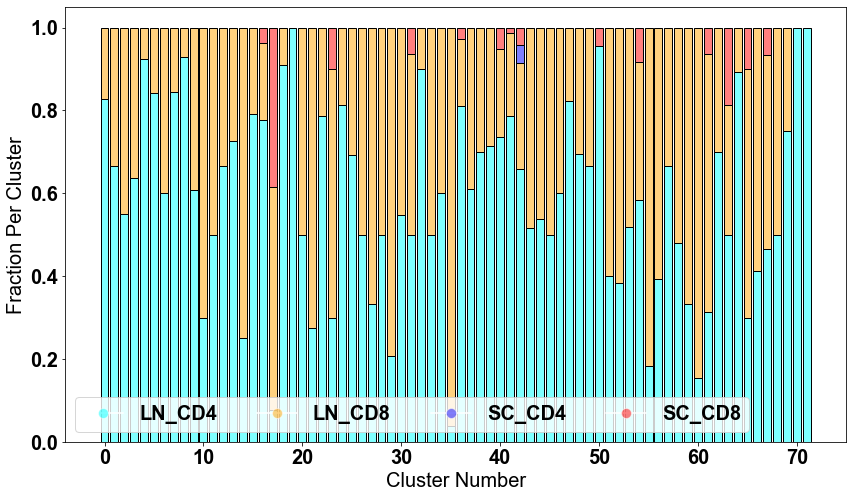

In [17]:
#########################
# Do you want to noramlize these bar plots or no?
norm = True
#########################

cmap3 = pl.get_cmap('tab20b')
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,8))

# Just in case your metadata has weird indices:
meta_map.index = cluster_dset.index
final_breakdown = pandas.concat([cluster_dset,meta_map],axis=1)
a = 0
for i in np.sort(final_breakdown['cluster'].drop_duplicates()):
    if i == -1:
        continue # Dont count the unclustered
    sub_clust = final_breakdown[final_breakdown['cluster'] == i]
    if len(sub_clust) == 0:
        continue
    bottom=0

    for j in sub_clust[meta_name].drop_duplicates().values:
        sub_sub = sub_clust[sub_clust[meta_name] == j]
        if norm:
            pl.bar(a,len(sub_sub)/len(sub_clust),bottom = bottom,color=keep_map[int(j)],edgecolor='black')
            bottom += len(sub_sub)/len(sub_clust)
        else:
            pl.bar(a,len(sub_sub),bottom = bottom,color=keep_map[int(j)],edgecolor='black')
            bottom += len(sub_sub)
    a = a+1

if len(meta_leg) < 6:
    meta_legF = np.array(meta_leg).reshape(len(meta_leg))
    legend_elements= []
    for j in np.arange(len(meta_leg)):
        element = [Line2D([0], [0], marker='o', color='w', label=meta_legF[j],markerfacecolor=keep_map[j], markersize=10)]
        legend_elements = legend_elements+element
    pl.legend(handles=legend_elements,ncol=len(meta_leg))
pl.xlabel('Cluster Number')
if norm:
    pl.ylabel('Fraction Per Cluster')
else:
    pl.ylabel('Count Per Cluster')

cluster_purity = aims.calc_cluster_purity(final_breakdown,meta_name)
print("Cluster Purities:")
print(np.transpose(cluster_purity))

#pl.savefig(outputDir+'/AIMS_clusterQuant.pdf',format='pdf')

# Section 8: Defining Data Subsets of Interest to Further Characterize Repertoire
VERY IMPORTANT STEP here for all downstream analysis. Define whether you want to compare/contrast clustered sequences or analyze sequences based upon the associated metadata

In [18]:
# Decide if you want to analyze the data by cluster or by metadata.
subset_sel = 'cluster' # other option is 'metadata'
#subset_sel = 'metadata'

# Then, Plot This Dataset of Interest and Visualize How Similar/Different Each Look

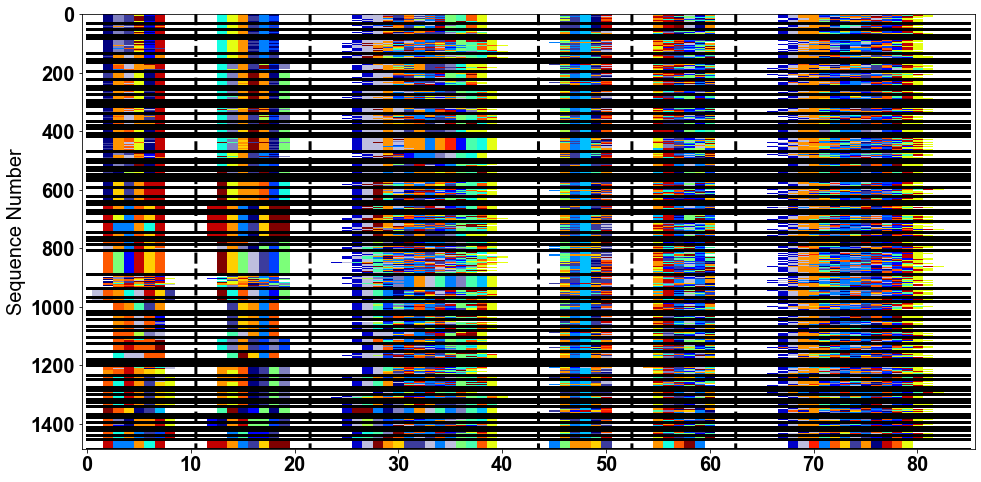

In [19]:
if subset_sel.lower() == 'cluster':
    chosen_map = clust_map; chosen_name = clust_name
elif subset_sel.lower() == 'metadata':
    chosen_map = meta_map; chosen_name = meta_name
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
for i in np.sort(chosen_map[chosen_name].drop_duplicates()):
    if i == -1:
        continue
    pre_clust = seq_MIf[seq_MIf.columns[chosen_map[chosen_map[chosen_name] == i].index]]
    clustID = np.transpose(pandas.DataFrame(i*np.ones(np.shape(pre_clust)[1])))
    clustID.columns = pre_clust.columns
    pre_clustF = pandas.concat([pre_clust,clustID],axis=0)
    if i == 0:
        clustered = pre_clustF
    else:
        clustered = pandas.concat([clustered, pre_clustF],axis = 1)
    ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*(np.shape(clustered)[1]),'black',linewidth = 3)
ax[0,0].set_ylabel('Sequence Number')
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(np.shape(clustered)[1]),np.arange(np.shape(clustered)[1]),'k--',linewidth = 3)
xyz = ax[0,0].imshow(np.transpose(np.array(clustered))[:,:-1], interpolation='nearest', aspect='auto',cmap=cmap)
#pl.savefig(outputDir+'/AIMS_'+subset_sel+'_subViz_umap.pdf',format='pdf')

# Section 9: Isolation of Individual Groups for Downstream Characterization
Run the next cell to visualize your clusters of choice, and then go through the remainder of the AIMS modules

Selecting the sub_sels [0,1] will select either the first two clusters or the first two metadata entries. Remember that python is 0-indexed, so if you want to look at a very specific metadata cluster then make sure you take that into account! You can *technically* visualize every cluster all at once, but that is REALLY not recommended

# NOTE: One thing that I noticed running this on multiple machines. The clusters themselves appear to be preserved, but the cluster #'s can change.
This is especially true if you're using different versions certain python modules. I'll make sure that I post the "correct" versions on the GitHub ReadMe

Visualizing the subsets: ['cluster17', 'cluster23']


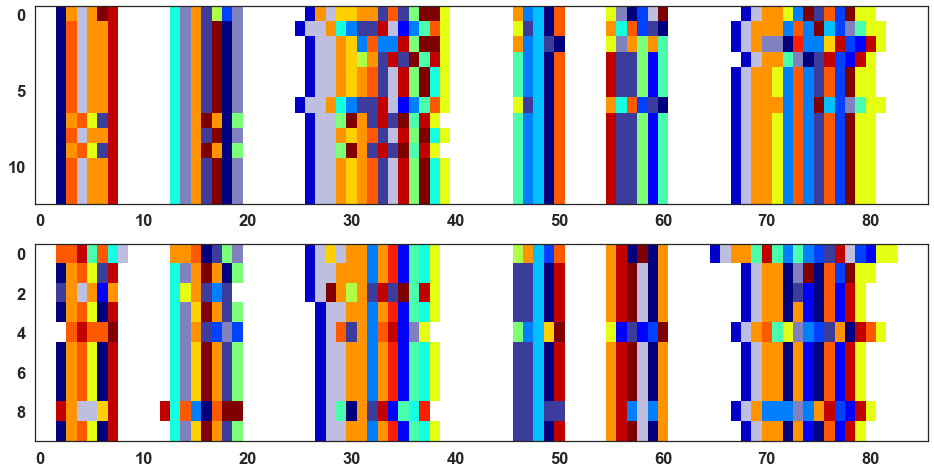

In [44]:
# So now that we've done some clustering, pick out the most interesting or sections of the data:
if molecule.lower() == 'msa':
    sub_sels = [0,1,2]
else:
    # THESE ARE THE FOUR CLUSTERS OF INTEREST FOR THE MANUSCRIPT
    #sub_sels = [63,65]
    sub_sels = [17,23]

# Do you want to save each individual cluster of sequences as an AIMS-compatible file?
seqlogo = False; save_subSeqs = False
# OPTIONALLY YOU CAN VISUALIZE/ANALYZE EVERY CLUSTER. STRONGLY NOT RECOMMENDED IF YOU HAVE MANY CLUSTERS
##sub_sels = np.arange(len(chosen_map))

# Redefine the raw sequences so we can manipulate them if needed
dset = seqF
fig, ax = pl.subplots(len(sub_sels), 1,squeeze=False,figsize=(16,4*len(sub_sels)))
label=[]
a = 0
for i in sub_sels:
    # Look at umap dset or pca dset
    sub_MI = seq_MIf[seq_MIf.columns[chosen_map[chosen_map[chosen_name] == i].index]]
    sub_seqs = np.transpose(dset[sub_MI.columns])
    if subset_sel.lower() == 'metadata':
        label.append(meta_legF[i])
    else:
        label.append('cluster'+str(i))
    ax[a,0].imshow(np.transpose(sub_MI), interpolation='nearest', aspect='auto',cmap=cmap)

    datlen = np.shape(sub_MI)[1]
    datID = np.transpose(pandas.DataFrame(datlen*[a]))
    datID.columns = sub_MI.columns
    sub_matPRE = pandas.concat([sub_MI,datID],axis=0)
    if a == 0:
        sub_matF = sub_matPRE
        sub_seqF = sub_seqs
    else:
        sub_matF = pandas.concat([sub_matF,sub_matPRE],axis=1)
        sub_seqF = pandas.concat([sub_seqF,sub_seqs],axis=0)
    a+=1 

    if save_subSeqs:
        sub_seqs.to_csv(outputDir+'/'+label[i]+'_all.txt',header=None,index=None)
    if seqlogo:
        seqlogo1 = sub_seqs[sub_seqs[0].str.len() == 14]
        seqlogo1.to_csv(outputDir+'/'+label[i]+'_logo.txt',header=None,index=None)

print("Visualizing the subsets: "+str([str(a) for a in label]))
#pl.savefig(outputDir+'/AIMS_'+subset_sel+'_selected.pdf',format='pdf')

# Alright so now we have our clusters, now need to match these up to the GEX data and see if anything pops out

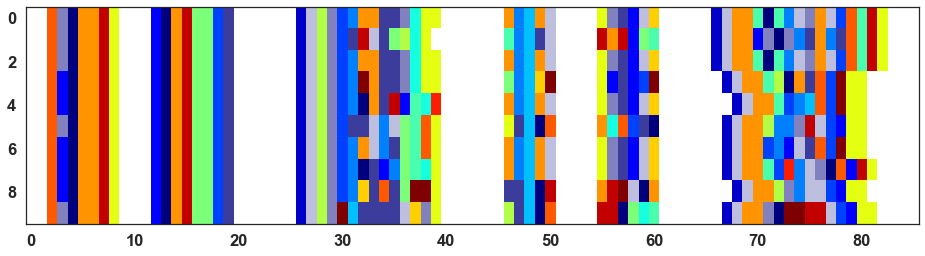

In [55]:
#########################################################################################
# We do a little bit of processing here to visualize the data more efectively
int_clust = 65
#########################################################################################
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,4))

sub_MI = seq_MIf[seq_MIf.columns[chosen_map[chosen_map[chosen_name] == int_clust].index]]
sub_seqs = np.transpose(dset[sub_MI.columns])
sub_index = sub_seqs.index

# Make the indices match the columns of what we find:
partition_df.index = seq_MIf.columns
gex_cluster_df.index = seq_MIf.columns
gex_filtered_df.index = seq_MIf.columns
# The real key:
sub_gex = gex_filtered_df.loc[sub_index]

# So here we actually pull out the indices of the cells from clusters 17 and 23
# for the explicit purpose of making our figures prettier. We basically just order
# TCRs with similar sequences and TCRs from specific tissues. This will hold
# for all downstream analysis...
order_seqs = True
if order_seqs:
       if int_clust == 17:
              ordered17 = ['LN_CD4_1081','LN_CD8_782', 'LN_CD8_274','LN_CD8_230','LN_CD8_1439', 'LN_CD8_852',
                     'LN_CD8_974', 'LN_CD8_1596','SC_CD8_37','SC_CD8_31',
                     'SC_CD8_41', 'SC_CD8_51', 'SC_CD8_55']
              seq_sub17 = sub_seqs.loc[ordered17]
              sub_MI17 = sub_MI[ordered17]
              sub_gex17 = sub_gex.loc[ordered17]
              ax[0,0].imshow(np.transpose(sub_MI17), interpolation='nearest', aspect='auto',cmap=cmap)
       elif int_clust == 23:
              ordered23 = ['LN_CD4_1343','LN_CD8_205','LN_CD8_1295','LN_CD4_1580', 'LN_CD4_2964', 'LN_CD8_181',
                     'LN_CD8_217', 'LN_CD8_330', 'LN_CD8_1110', 'SC_CD8_63']
              seq_sub23 = sub_seqs.loc[ordered23]
              sub_MI23 = sub_MI[ordered23]
              sub_gex23 = sub_gex.loc[ordered23]
              ax[0,0].imshow(np.transpose(sub_MI23), interpolation='nearest', aspect='auto',cmap=cmap)
       else:
              ax[0,0].imshow(np.transpose(sub_MI), interpolation='nearest', aspect='auto',cmap=cmap)
else:
       ax[0,0].imshow(np.transpose(sub_MI), interpolation='nearest', aspect='auto',cmap=cmap)

#pl.savefig(outputDir+'/subViz.pdf',format='pdf')

(-5.5, 4.0)

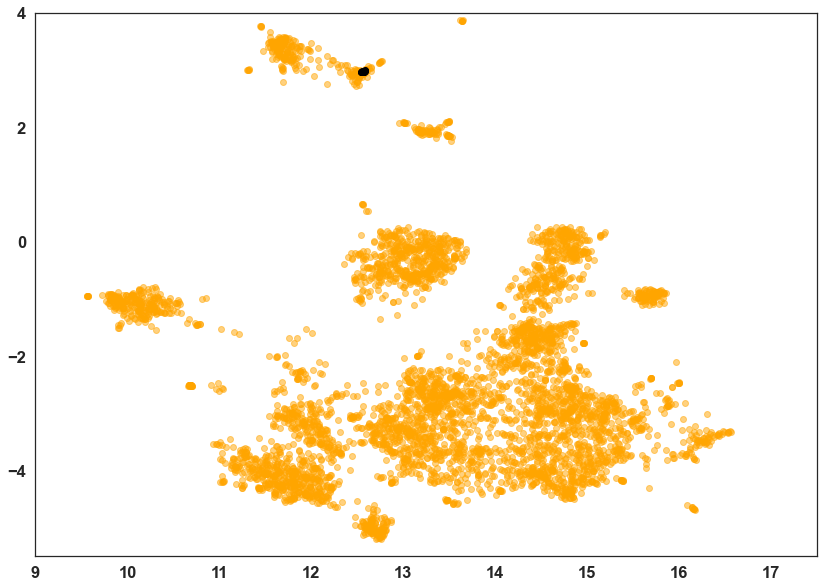

In [56]:
# This is a script to visualize WHERE in space the cluster is.
# Should probably find a way to work this into the main version of the script...

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
clust_sub = pandas.DataFrame(clust_input,index = seq_MIf.columns).loc[sub_seqs.index]

pl.scatter(clust_input[:,0],clust_input[:,1],color='orange',alpha=0.5)
pl.scatter(clust_sub[0].values,clust_sub[1].values,color='black')

pl.xlim([9,17.5])
pl.ylim([-5.5,4])
#pl.savefig(outputDir+'/clust_loc.pdf',format='pdf')

# And now here is where we visualize the GEX
We cycled through a couple of different gene combinations, we'll leave them here again for *data exploration*

Text(0.5, 0, 'Cell Number')

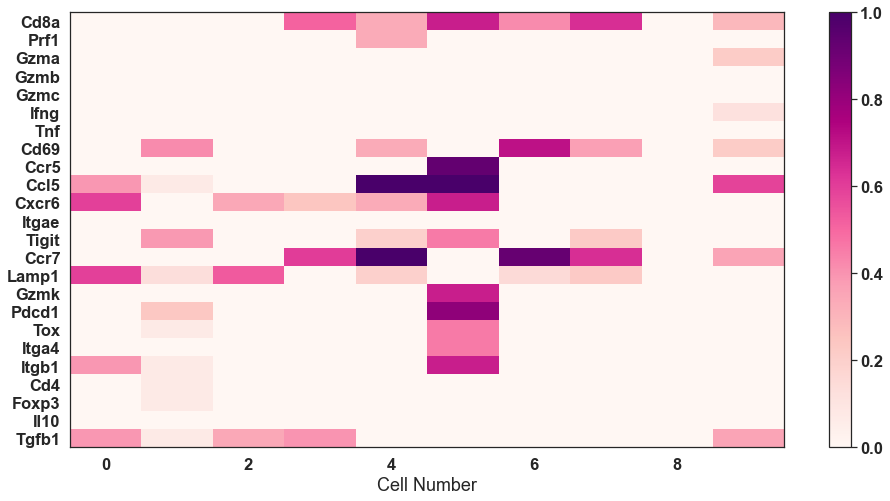

In [57]:
# Gene panels stolen from Szabo et al. Nature Communications 2019
# "Single-cell transcriptomics of human T cells reveals tissue and activation signatures in health and disease"
cd4_rest_genes = ['Cd4','Tcf7','Id3','Ccr7','Aqp3','Sell','Lgals3']
cd4_active_genes = ['Cd4','Il4ra','Stat1','Mal','Socs1','Il2','Psat1',
                    'Pycr1','Tnf','Mir155hg','Nme1','Il2ra','Ctla4']
cd4_treg_genes = ['Tnfrsf18','Foxp3','Il2ra','Ctla4','Tigit','Pmch']
cd8_rest_genes = ['Lgals1','Rgs1','Gzmk','Cxcr6','Anxa2','Itga1']
cd8_active_genes = ['Gzmb','Ifng','Xcl1','Ccl4','Ccl3']
manuscript_panel = ['Cd8a','Prf1', 'Gzma', 'Gzmb', 'Gzmc', 'Ifng', 'Tnf','Cd69', 'Ccr5','Ccl5', #'Klrg1'
                'Cxcr6','Itgae','Tigit','Ccr7','Lamp1','Gzmk', 'Pdcd1','Tox','Itga4','Itgb1', #'Eomes'
                'Cd4','Foxp3','Il10','Tgfb1']

# defining "key_genes" lets you easily select and visualize one of these gene panels
key_genes=manuscript_panel

temp_gex = []
for gene in key_genes:
    if order_seqs:
        if int_clust == 17:
            temp_gex = temp_gex + [sub_gex17[gene].values]
        elif int_clust == 23:
            temp_gex = temp_gex + [sub_gex23[gene].values]
        else:
            temp_gex = temp_gex + [sub_gex[gene].values]
    else:
        temp_gex = temp_gex + [sub_gex[gene].values]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))

gex_temp_df = pandas.DataFrame(temp_gex)

##########################################################################################
# Either include every entry, or drop GEX dropouts from the plots
# We have some TCRs with no associated GEX. No need to show those blank columns
drop_gex = False
drop_clones = [0,7,10]
if drop_gex:
    gex_dropDF = gex_temp_df.drop(labels=drop_clones,axis=1)
else:
    gex_dropDF = gex_temp_df
##########################################################################################

x= pl.imshow(gex_dropDF,interpolation='nearest',aspect='auto',cmap=cm.RdPu,vmax=1.0)
pl.colorbar(x)

a = ax[0,0].set_yticks(np.arange(len(key_genes)))
a = ax[0,0].set_yticklabels(key_genes)

pl.xlabel('Cell Number')

#pl.savefig(outputDir + '/gex_view.pdf',format='pdf')

# Ok and Lastly We're Actually Going to Quickly Deviate from Anything AIMS Related
We're just going to show the gene expression for entire datasets. While probably Seurat or something could do this, we figured it might be nice for users if we let them does this here as well...

In [24]:
for data in ['SC_CD4_','SC_CD8_','LN_CD4_','LN_CD8_']:
    new_key = []
    for i in np.arange(len(sc_cd4_barcodes)):
        new_key = new_key + [data+str(i)]

    # T here is for "temporary"
    sub_MI_T = seq_MIf[new_key]
    sub_seqs_T = np.transpose(dset[sub_MI_T.columns])
    sub_index_T = sub_seqs_T.index
    if data == 'SC_CD4_':
        sc_cd4_gex = gex_filtered_df.loc[sub_index_T]
    elif data == 'SC_CD8_':
        sc_cd8_gex = gex_filtered_df.loc[sub_index_T]
    elif data == 'LN_CD4_':
        ln_cd4_gex = gex_filtered_df.loc[sub_index_T]
    elif data == 'LN_CD8_':
        ln_cd8_gex = gex_filtered_df.loc[sub_index_T]

# And then lighlty reformat everything and pull out whatever genes of interest you want

In [25]:
# need to reshape the GEX matrix to make it Seaborn compatible

manuscript_genes = ['Cd8a','Cd69','Tigit','Ccr7','Itga4','Itgb1','Pdcd1','Gzmk']

d1 = pandas.concat([ sc_cd8_gex,pandas.DataFrame(['SC_CD8']*len(sc_cd8_gex),columns = ['Name'],index = sc_cd8_gex.index)],axis=1)
d2 = pandas.concat([ ln_cd8_gex,pandas.DataFrame(['LN_CD8']*len(ln_cd8_gex),columns = ['Name'],index = ln_cd8_gex.index)],axis=1)
d3 = pandas.concat([ sc_cd4_gex,pandas.DataFrame(['SC_CD4']*len(sc_cd4_gex),columns = ['Name'],index = sc_cd4_gex.index)],axis=1)
d4 = pandas.concat([ ln_cd4_gex,pandas.DataFrame(['LN_CD4']*len(ln_cd4_gex),columns = ['Name'],index = ln_cd4_gex.index)],axis=1)
NEW = pandas.concat([d1,d2,d3,d4],axis=0)

first = True
for i in manuscript_genes:
    gex_save = NEW[i].values
    name_col = [i]*len(gex_save)
    temp=np.transpose(pandas.DataFrame([name_col,gex_save,NEW['Name']],index=['Gene','GEX','Name']))
    if first:
        sns_df = temp
        first = False
    else:
        sns_df = pandas.concat([sns_df,temp],axis=0)

# Now plot it all!

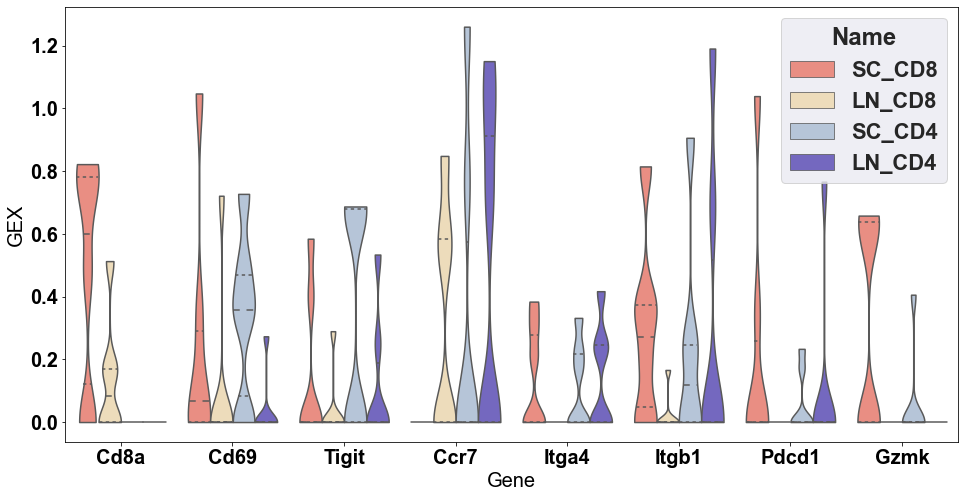

In [26]:
import seaborn as sns
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))

sns.set(rc={'figure.figsize':(14,10)})

sns_df['GEX'] = sns_df['GEX'].astype(float)

gex_normal = sns_df[sns_df["GEX"]<0.4]
gex_outlier = sns_df[sns_df['GEX']>=10]

sns.set(font_scale=2)

# Alright so scaling to the width was the way to actually see this again. 
g = sns.violinplot(data=sns_df.reset_index(),x='Gene',y='GEX',hue='Name',bw=0.25,cut=0, scale='width',height=8,inner='quartile',aspect=2,axis=ax,palette = ['Salmon','Wheat','lightsteelblue','slateblue'])
#g.set(ylim=(-1, 10))
#pl.savefig(outputDir+'/GEX_violin_normal_all.pdf',format='pdf')


# Alright from here on down it is just standard AIMS analysis, nothing too wild

# Leaving This Here in Case You Have Seqlogo Installed
Can be useful to visualize some sequences in this way. This code has not been tested in a while, and has not been tested at all for MSA analysis

In [27]:
%%bash
# Alright let's cheat and just use the seqlogo in bash... the python script is a little bit of a pain.
# Code is from reference: 
#Crooks GE, Hon G, Chandonia JM, Brenner SE WebLogo: A sequence logo generator, Genome Research, 14:1188-1190, (2004)

# Obviously, change this path to wherever YOUR seqlogo is and whatever your filename is
#weblogo/seqlogo -F PDF -c -n -Y -f sub1_logo.txt > sub1_logo.pdf

# Section 10: Generate Subsets of Matrices We Have Calculated Previously
This will save some time compared to how things were done before.

In [28]:
# define "RE" variables so we don't mess with any variables upstream (in case you want to re-run)
full_big_re = full_big; full_big_re.index = seq_MIf.columns
parsed_mat_re = parsed_mat; parsed_mat_re.index = seq_MIf.columns
# use the transpose of the sub_mat to find the 
ref_sub = np.transpose(sub_matF)
ref_sub.columns = np.arange(len(sub_matF))

sub_big = full_big_re.loc[sub_matF.columns]
sub_parsed = parsed_mat_re.loc[sub_matF.columns]


# Section 11: Position Sensitive Biophysical Properties for Every Clone in the Dataset
Here, we can visualize the how similar or dissimilar the biophysical properties are for each sequence within a given repertoire.

Right now we show only the charge and the hydropathy, but you can change "prop1" in either cell to visualize a different property (see ReadTheDocs for more info)

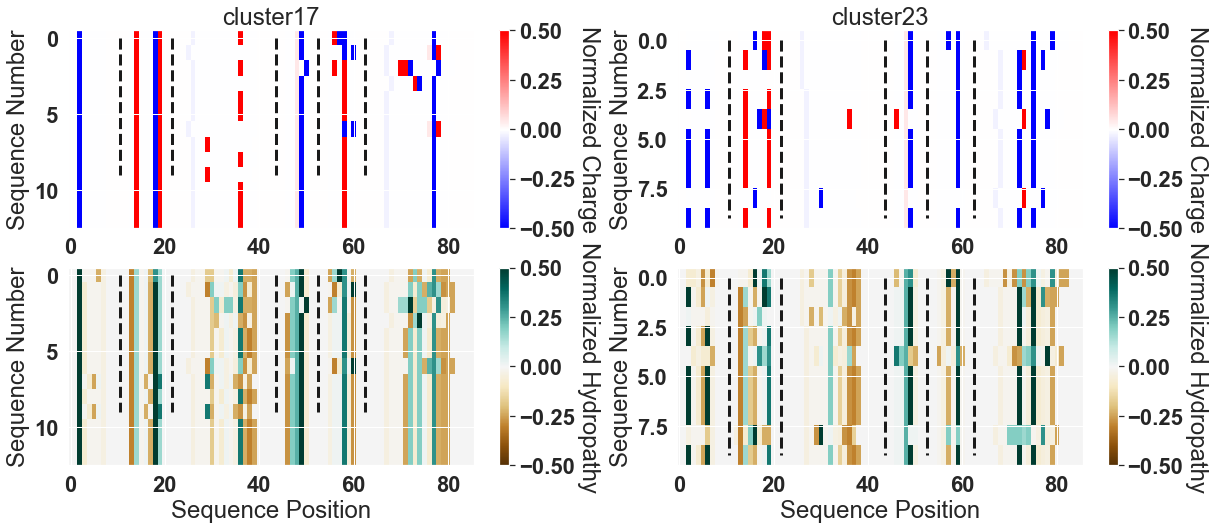

In [29]:
# Generate the position sensitive charge across all clones in the dataset
# Which property will you want to look at down the line? 1 = charge, 2 = hydrophobicity... see full list in eLife paper (Boughter et al. 2020)

fig, axs = pl.subplots(2, len(sub_sels),squeeze=False,figsize=(10*len(sub_sels),8))

prop1 = 1

for dat in np.arange(len(sub_sels)):
    take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
    take_big = sub_big.loc[take_sub]
    temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
    x = axs[0,dat].imshow(temp_bigReshape[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.bwr, vmin = -0.5, vmax = 0.5)
    #axs[0,dat].set_xlabel('Sequence Position'); 
    axs[0,dat].set_ylabel('Sequence Number')
    axs[0,dat].set_title(str(label[dat]))
    cbar = fig.colorbar(x, ax=axs[0,dat])
    cbar.set_label('Normalized Charge', rotation=270,labelpad=25)

prop2 = 2
for dat in np.arange(len(sub_sels)):
    take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
    take_big = sub_big.loc[take_sub]
    temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
    x = axs[1,dat].imshow(temp_bigReshape[:,prop2,:],interpolation='nearest', aspect='auto',cmap=cm.BrBG, vmin = -0.5, vmax = 0.5)
    axs[1,dat].set_xlabel('Sequence Position'); axs[1,dat].set_ylabel('Sequence Number')

    cbar = fig.colorbar(x, ax=axs[1,dat])
    cbar.set_label('Normalized Hydropathy', rotation=270,labelpad=25)

if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        axs[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(10),np.arange(10),'k--',linewidth = 3)
        axs[0,1].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(10),np.arange(10),'k--',linewidth = 3)
        axs[1,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(10),np.arange(10),'k--',linewidth = 3)
        axs[1,1].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(10),np.arange(10),'k--',linewidth = 3)

#pl.savefig(outputDir+'/AIMS_'+subset_sel+'_posSensProps.pdf',format='pdf')

# Section 12: Averaged Biophysical Properties for Each Group of Interest
Look at biophysical properties averaged over clones AND position

Note for old users of the software, you might get different looking results because originally I normalized vectors to unit length, but NOT 0 mean. I now do both.

Text(0, 0.5, 'Normalized Property Value')

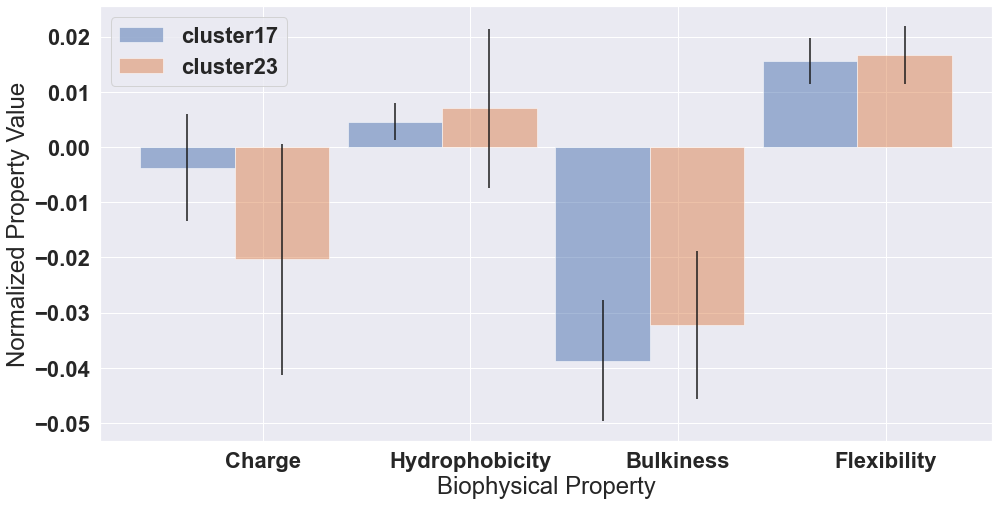

In [30]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# We want to exclude prop0 (the simple 1-21 AA representation entries)
full_avg = []; full_std = []
for dat in np.arange(len(sub_sels)):
    sin_avg =[]; sin_std = []
    for prop in np.arange(4):
        # We don't want to plot prop1, we want to plot the rest of them
        propF = prop+1
        take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
        take_big = sub_big.loc[take_sub]
        temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
        plot_avg = np.average(np.average(temp_bigReshape[:,propF,:],axis=1))
        plot_std = np.std(np.std(temp_bigReshape[:,propF,:],axis=1))
        sin_avg.append(plot_avg)
        sin_std.append(plot_std)
        
    full_avg.append(sin_avg)
    full_std.append(sin_std)

for i in np.arange(len(sub_sels)):
    ax[0,0].bar(x_axis+i/len(sub_sels), full_avg[i],yerr = full_std[i],alpha = 0.5, width = 1/len(sub_sels))
    #ax[0,0].bar(x_axis+i/len(sub_sels), full_avg[i],alpha = 0.5, width = 1/len(sub_sels))
        
ax[0,0].legend(label)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Bulkiness','Flexibility'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#pl.savefig(outputDir+'/AIMS_'+subset_sel+'_netAvgProp.pdf',format='pdf')

# Section 13: Position-Sensitive Averaged Biophysical Properties
Here we effectively average the figures from section 11 over the y-axes, giving a general idea of trends in the biophysical properties of within-group sequences

NOTE: This figure frequently looks chaotic/hard to parse for MSA analysis. More useful for Ig analysis

Text(0, 0.5, 'Normalized Hydropathy')

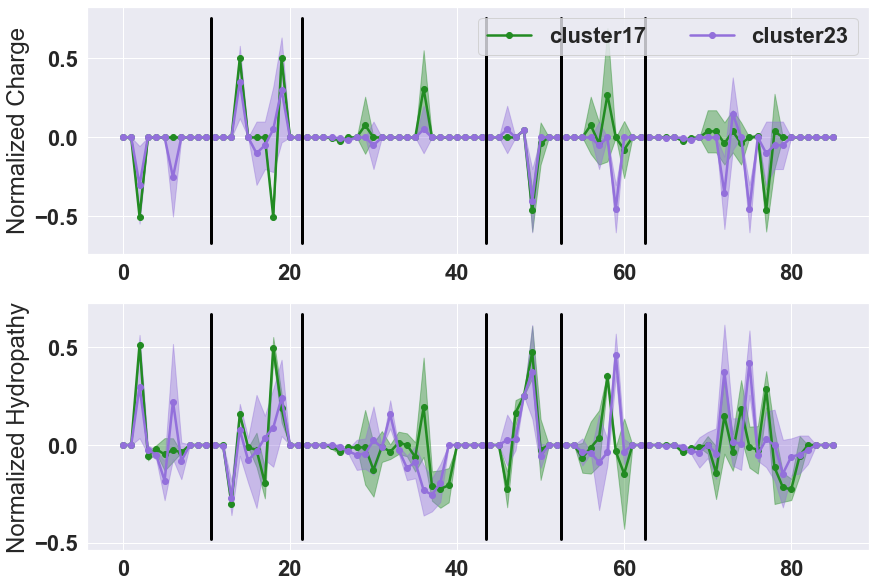

In [31]:
# Now get the position sensitive avarege biophysical properties
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
prop_sel = [1,2]
full_avg = []; full_std = []
a = 0
color1=['forestgreen','mediumpurple']
for prop in prop_sel:
    b=0
    for dat in np.arange(len(sub_sels)):
        take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
        take_big = sub_big.loc[take_sub]
        temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
        plot_avg = np.average(temp_bigReshape[:,prop,:],axis=0)
        plot_std = np.std(temp_bigReshape[:,prop,:],axis=0)

        ax[a,0].plot(plot_avg,marker='o',linewidth=2.5,color=color1[b])
        ax[a,0].fill_between(np.arange(len(plot_avg)),plot_avg+plot_std,plot_avg-plot_std,alpha=0.4,color=color1[b])

        #for line in temp_bigReshape[:,prop,:]:
        #    ax[a,0].plot(line,'--',alpha=0.5,color=color1[b])
        b+=1
    a+=1

# Draw some nice lines to guide 
y11, y12 = ax[0,0].get_ylim();y21, y22 = ax[1,0].get_ylim()
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y11,y12,100),'black',linewidth = 3)
        ax[1,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y21,y22,100),'black',linewidth = 3)


ax[0,0].legend(label,loc='upper right',ncol=2)
ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydropathy')
#pl.savefig(outputDir+'/AIMS_posSensAvg.pdf',format='pdf')

# Section 14: Information Theoretic Calculations
Use the Shannon Entropy and Mutual Information to quantify the diversity and inter-relations between the amino acids used in each sequence within a group

NOTE: These metrics are more useful for large datasets, less so far small datasets from DBSCAN or OPTICS identified clustered

Also NOTE: Again, these plots can be a bit hard to interpret for longer MSA sequences. Just too many points to read.

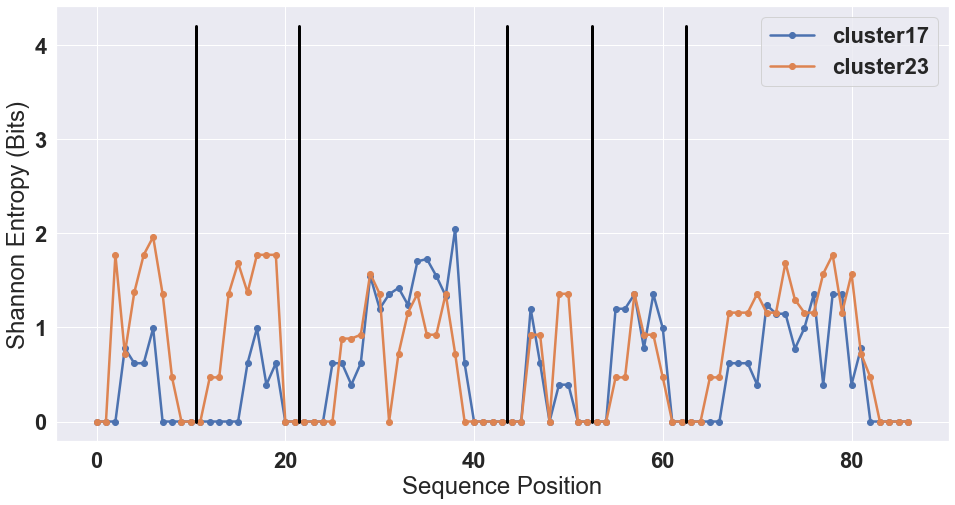

In [32]:
# Calculate the Shannon Entropy, a proxy for diversity
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
poses = len(seq_MIf)
entropy = []; frequencies = []
for dat in np.arange(len(sub_sels)):
    temp_MI = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == dat].index]
    entropy_pre,freq_pre = aims.calculate_shannon(np.transpose(np.array(temp_MI)))
    pl.plot(entropy_pre,marker='o',linewidth=2.5)
    entropy.append(entropy_pre); frequencies.append(freq_pre)

# So all of this commented out code is explicitly for making the figure in the manuscript
# I'll leave it here just in case. But basically when you are picking out subsets,
# you can save each "sub_MI" as "sub_MI#" where # is the number of the cluster
# Need to do this by hand unfortunately, but then it is easy...
# NOTE: You also need to comment out the above plotting code.
#entropy17,freq_pre17 = aims.calculate_shannon(np.transpose(np.array(sub_MI17)))
#entropy23,freq_pre23 = aims.calculate_shannon(np.transpose(np.array(sub_MI23)))
#entropy63,freq_pre63 = aims.calculate_shannon(np.transpose(np.array(sub_MI63)))
#entropy65,freq_pre65 = aims.calculate_shannon(np.transpose(np.array(sub_MI65)))
#entropyFull,freq_preFull = aims.calculate_shannon(np.transpose(np.array(seq_MIf)))
#pl.plot(entropy17,marker='o',linewidth=2.5);pl.plot(entropy23,marker='o',linewidth=2.5)
#pl.plot(entropy63,marker='o',linewidth=2.5);pl.plot(entropy65,marker='o',linewidth=2.5)
#pl.plot(entropyFull,marker='o',linewidth=2.5,color='black')
#pl.legend(['Cluster17','Cluster23','Cluster63','Cluster65','Full Dataset'],ncol=5,bbox_to_anchor=(1.01, 1.125))

pl.legend(label)
pl.xlabel('Sequence Position'); pl.ylabel('Shannon Entropy (Bits)')

if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,4.2,100),'black',linewidth = 3)
#pl.savefig(outputDir+'/AIMS_entropy.pdf',format='pdf')

# NOTE: The Mutual Information Calculation Can Be Quite Slow
Especially the case for MSAs with many amino acids. 

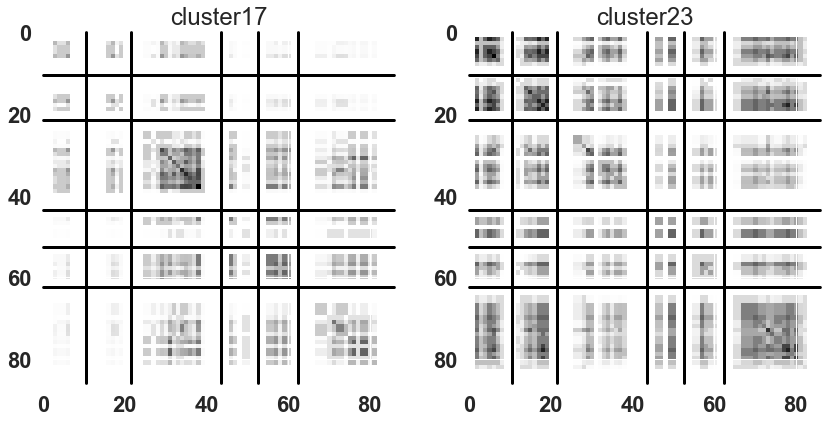

In [33]:
# And then the mutual information:
fig, ax = pl.subplots(1, len(sub_sels),squeeze=False,figsize=(14,5*len(sub_sels)))

poses = len(seq_MIf)
MI = []; ent_cond = []; count = []
for dat in np.arange(len(sub_sels)):
    temp_MI = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == dat].index]
    MI_pre,ent_cond_pre,count_pre = aims.calculate_MI(np.transpose(np.array(temp_MI)))
    ax[0,dat].imshow(MI_pre,vmin=0,vmax=2,cmap=cm.Greys)
    MI.append(MI_pre); ent_cond.append(ent_cond_pre); count.append(count_pre)
    ax[0,dat].set_title(label[dat])

#pl.colorbar(x)
# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        for j in np.arange(len(sub_sels)):
            ax[0,j].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
            ax[0,j].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

#pl.savefig(outputDir+'/AIMS_MI.pdf',format='pdf')

# Section 15: Binary Comparisons Between Datasets
Anything from here on requires a comparison between only two datasets. This can be two clusters, two loaded in files, two metadata subsets, whatever.

You can continue on from the previous sections even if you were analyzing multiple datasets. The analysis will just, by default, compare only the first two datasets

Text(0, 0.5, 'Sequence Position')

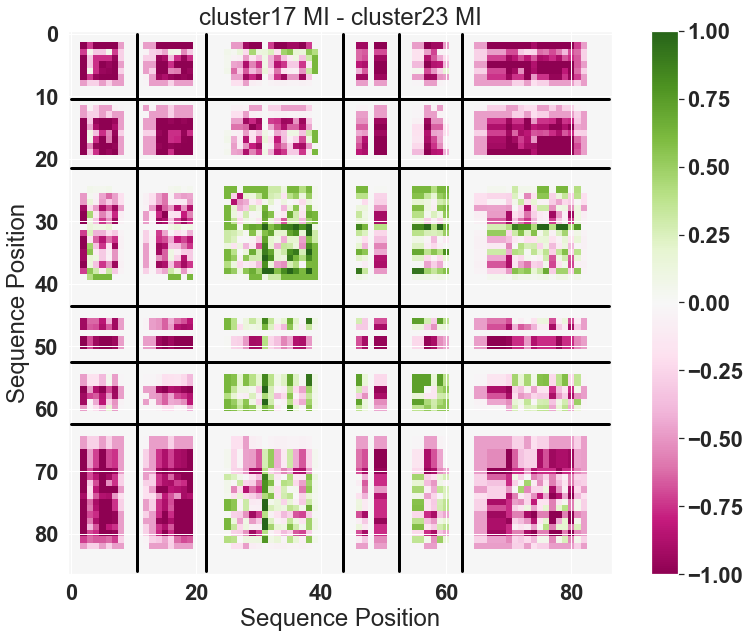

In [34]:
# A bit easier to look at the DIFFERENCE in mutual information:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
x = pl.imshow(MI[0] - MI[1], cmap=cm.PiYG, vmin = -1, vmax = 1)
pl.colorbar(x); pl.title(str(label[0])+ ' MI - ' + str(label[1]) + ' MI')

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot((mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
        ax[0,0].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

pl.xlabel('Sequence Position'); pl.ylabel('Sequence Position')
#pl.savefig(outputDir+'/AIMS_MIdiff.pdf',format='pdf')

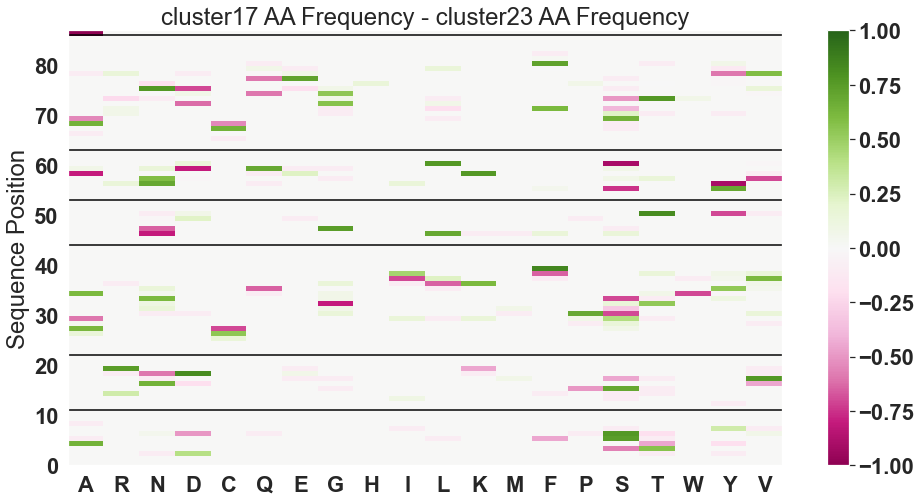

In [35]:
# Calculate the probabilities of seeing each amino acid at each position
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.title(str(label[0])+ ' AA Frequency - ' + str(label[1]) + ' AA Frequency')
freqMax = np.max(frequencies[0][:,1:]-frequencies[1][:,1:]); freqMin = np.min(frequencies[0][:,1:]-frequencies[1][:,1:])
freqBound = max(abs(freqMax),abs(freqMin))
x=ax[0,0].pcolormesh(frequencies[0][:,1:]-frequencies[1][:,1:],vmin=-freqBound,vmax=freqBound,cmap=cm.PiYG)
AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
pl.colorbar(x); pl.ylabel('Sequence Position')
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=AA_key)

place=0
if type(mat_size) == int:
    pl.plot(np.arange(21),place*np.ones(21),'black')
else:
    for i in mat_size:
        place += i
        pl.plot(np.arange(21),place*np.ones(21),'black')

#pl.savefig('AIMS_freqDiff.pdf',format='pdf')

# Alright Now We Need to Bring Back in Linear Discriminant Analysis

/opt/anaconda3/envs/immunopep/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/immunopep/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Classification Accuracy
1.0


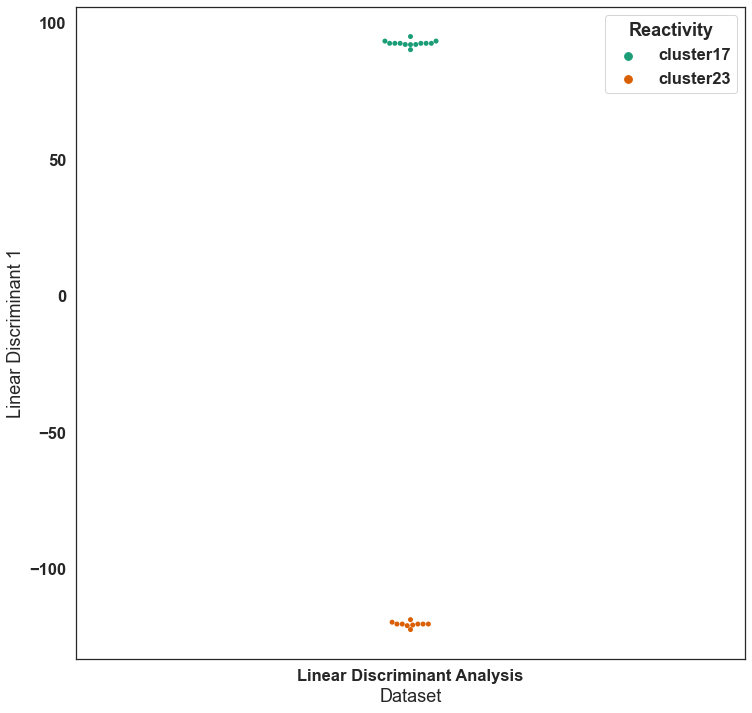

In [43]:
bigass1 = full_big_re.loc[ref_sub[ref_sub[len(sub_matF)-1] == 0].index]
seq1_len = len(bigass1)
bigass1.index = np.arange(seq1_len)
bigass2 = full_big_re.loc[ref_sub[ref_sub[len(sub_matF)-1] == 1].index]
seq2_len = len(bigass2)
bigass2.index = np.arange(seq2_len)

######### Run the actual classification here ###############
# Change the matSize variable to alter the number of vectors used to generate a classification
bigF,weights,acc_all,mda_all,final,top_names = classy.do_linear_split(bigass1,bigass2,got_big=True,matSize=10)
############################################################

import seaborn as sns
fig = pl.figure(figsize = (12, 12))
PLOTdset = ["Linear Discriminant Analysis" for x in range(seq1_len+seq2_len)]
reacts = [label[0] for x in range(seq1_len)] + [label[1] for x in range(seq2_len)]

d1 = {'Dataset': PLOTdset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")
print("Classification Accuracy")
print(acc_all)
#pl.savefig(outputDir+'/AIMS_digram.pdf',format='pdf')

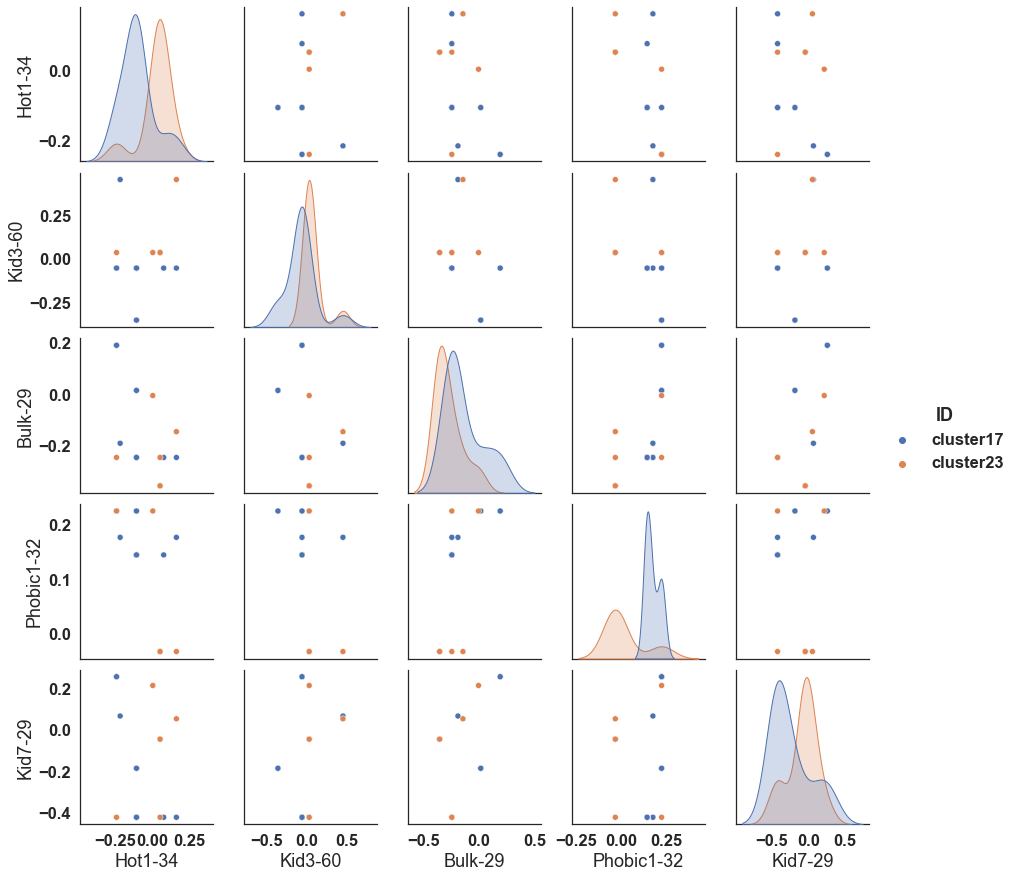

In [37]:
# Show the top properties that differentiate the two populations
# show_top = how many of these top values do you want to show? don't recommend more than ~5
# solely due to how busy the figure gets
# Again, see eLife paper for biophysical property definitions
import seaborn as sns
show_top = 5
dset_parse = final[top_names[0:show_top]]
dset_ID_pre1 = bigF['ID']
dset_ID_pre2 = dset_ID_pre1.replace(1.0,label[0])
dset_ID = dset_ID_pre2.replace(2.0,label[1])

bigass_parse_dset = pandas.concat([dset_parse,dset_ID],axis = 1)
sns.pairplot(bigass_parse_dset,hue = 'ID')
#pl.savefig(outputDir+'/AIMS_pairplot.pdf',format='pdf')

# Detailed Amino Acid Frequency Breakdowns
This feature is most useful in peptide analysis, but could be useful for general repertoire comparisons

Text(0.5, 0, 'Amino Acid')

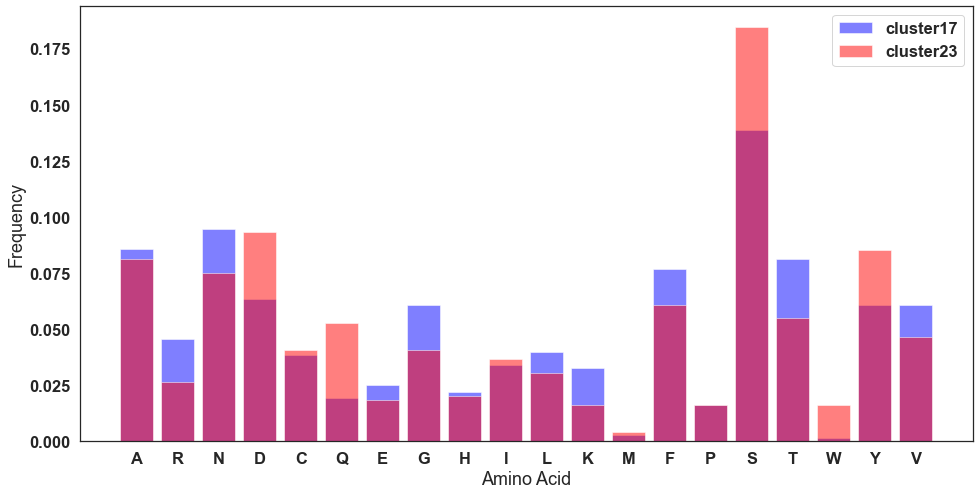

In [38]:
# Need to get back just our sequences of interest.
seq1 = sub_seqF.loc[ref_sub[ref_sub[len(sub_matF)-1] == 0].index]
seq2 = sub_seqF.loc[ref_sub[ref_sub[len(sub_matF)-1] == 1].index]
# Calculate both position-insensitive amino acid frequency and digram frequencies
# Can either normalize to the # of sequences or total number of AA (num_seq or num_AA)
AA_freq_all1, digram_all1 = aims.full_AA_freq(seq1,norm='num_AA')
AA_freq_all2, digram_all2 = aims.full_AA_freq(seq2,norm='num_AA')

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].bar(np.arange(len(AA_freq_all1)),AA_freq_all1, color='blue',alpha=0.5)
ax[0,0].bar(np.arange(len(AA_freq_all2)),AA_freq_all2,color='red',alpha=0.5)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=AA_key)
ax[0,0].legend([label[0],label[1]])
#ax[1,0].legend([label[2],label[3]])
pl.ylabel('Frequency')
pl.xlabel('Amino Acid')
#pl.savefig(outputDir+'/AIMS_AAnetProb.pdf',format='pdf')

# Plot the Digram Frequencies Per Sequence (or per AA)
There can occasionally be interesting information in these digram patterns, particularly if there are notabe differences between populations.

Note, while the matrix could possibly appear symmetric, it need not be so. The y-axis gives the first amino acid in the digram, the x-axis gives the second. So on the x,y coordinate map, E (x-axis) and D (y-axis) gives the frequency of the digram DE.

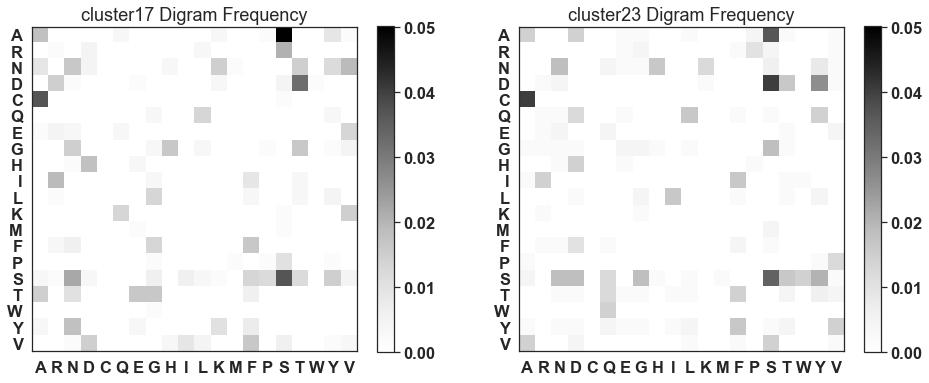

In [39]:
fig, ax = pl.subplots(int(len(label)/2), 2,squeeze=False,figsize=(16,12))
plot_max = np.max([np.max(digram_all1),np.max(digram_all2)])

ax[0,0].set_title(str(label[0])+ ' Digram Frequency')
ax[0,1].set_title(str(label[1])+ ' Digram Frequency')
x1 = ax[0,0].imshow(digram_all1,  cmap = cm.Greys,vmin=0,vmax=plot_max)
x2 = ax[0,1].imshow(digram_all2,  cmap = cm.Greys,vmin=0,vmax=plot_max)

xax=pl.setp(ax[0,0],xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax[0,0],yticks=np.arange(20),yticklabels=AA_key)
xax=pl.setp(ax[0,1],xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax[0,1],yticks=np.arange(20),yticklabels=AA_key)

fig.colorbar(x1, ax=ax[0, 0], shrink=0.5)
fig.colorbar(x2, ax=ax[0, 1], shrink=0.5)
#pl.savefig(outputDir+'/AIMS_digram.pdf',format='pdf')

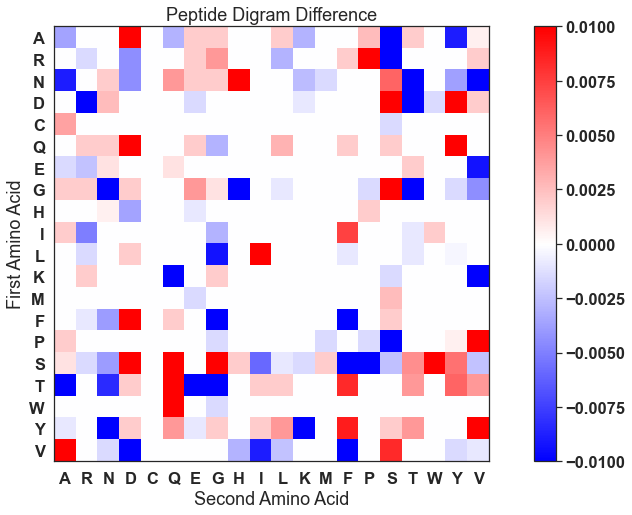

In [40]:
# Look at the difference in these digram frequencies
# For now, hard to say if these are necessarily significant, 
# more downstream analysis is needed to tease out conclusions
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.title('Peptide Digram Difference')
zzz = pl.imshow(digram_all2-digram_all1, vmin = -0.01, vmax = 0.01, cmap = cm.bwr)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax,yticks=np.arange(20),yticklabels=AA_key)
ax[0,0].set_ylabel('First Amino Acid')
ax[0,0].set_xlabel('Second Amino Acid')
pl.colorbar(zzz)
#pl.savefig(outputDir+'/AIMS_digramDiff.pdf',format='pdf')